In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import time
import pickle

from concurrent.futures import ProcessPoolExecutor, as_completed

import discretize 
from simpeg.utils import mkvc, plot_1d_layer_model
from simpeg import (
    maps,
    Data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)
from simpeg.electromagnetics import time_domain as tdem
from simpeg.utils.solver_utils import get_default_solver

from simpeg.meta import MultiprocessingMetaSimulation #DaskMetaSimulation

In [2]:
# from inversions_1d import create_inversion, run_inv

In [3]:
Solver = get_default_solver()
Solver

pymatsolver.direct.pardiso.Pardiso

# load data 

In [4]:
n_times_invert = 20

In [5]:
rx_locs = np.load("rx_locs.npy")

In [6]:
rx_locs

array([[-700., -700.,   30.],
       [-650., -700.,   30.],
       [-600., -700.,   30.],
       ...,
       [ 600.,  700.,   30.],
       [ 650.,  700.,   30.],
       [ 700.,  700.,   30.]])

In [7]:
def load_pre_file(filepath):
    """
    Load a GIF-style .pre file (TDoctree format).

    Parameters
    ----------
    filepath : str
        Path to the .pre-style data file

    Returns
    -------
    dict
        {
            "ignore": float or None,
            "n_trx": int,
            "transmitters": list of {
                "location": list of float,
                "n_recv": int,
                "n_time": int,
                "receivers": list of {
                    "loc": (x, y, z),
                    "time": float,
                    "data": list of float
                }
            }
        }
    """
    with open(filepath, "r") as f:
        lines = [line.strip() for line in f if line.strip()]

    i = 0
    ignore_value = None
    transmitters = []

    # Parse IGNORE line if present
    if lines[i].startswith("IGNORE"):
        ignore_value = float(lines[i].split()[1])
        i += 1

    # Parse number of transmitters
    if lines[i].startswith("N_TRX"):
        n_trx = int(lines[i].split()[1])
        i += 1
    else:
        raise ValueError("Missing N_TRX line")

    while i < len(lines):
        if lines[i].startswith("TRX_LOOP"):
            i += 1
            location = list(map(float, lines[i].split()))
            i += 1
            if not lines[i].startswith("N_RECV"):
                raise ValueError("Expected N_RECV")
            n_recv = int(lines[i].split()[1])
            i += 1
            if not lines[i].startswith("N_TIME"):
                raise ValueError("Expected N_TIME")
            n_time = int(lines[i].split()[1])
            i += 1

            receivers = []
            for _ in range(n_recv * n_time):
                parts = lines[i].split()
                x, y, z = map(float, parts[0:3])
                time = float(parts[3])
                data = list(map(float, parts[4:]))
                receivers.append({
                    "loc": (x, y, z),
                    "time": time,
                    "data": data
                })
                i += 1

            transmitters.append({
                "location": location,
                "n_recv": n_recv,
                "n_time": n_time,
                "receivers": receivers
            })
        else:
            i += 1  # Skip unknown or empty lines

    return {
        "ignore": ignore_value,
        "n_trx": len(transmitters),
        "transmitters": transmitters
    }


In [8]:
dobs = load_pre_file("dobs.txt")
# rx_times = np.array([dobs["transmitters"][0]["receivers"][j]["time"] for j in range(len(dobs["transmitters"][0]["receivers"]))])
# dobs = np.loadtxt("dobs.txt")[:, -2]

In [9]:
dobs_values = np.zeros((n_times_invert, len(dobs["transmitters"])))
for i in range(len(dobs["transmitters"])): 
    for j in range(n_times_invert): 
        dobs_values[j, i] = dobs["transmitters"][i]["receivers"][j]["data"][-2]

In [10]:
rx_times = np.load("rx_times.npy")

In [11]:
n_times_invert = len(rx_times)

# create survey

In [12]:
tx_height = rx_locs[0, 2]
source_list = []

for i in range(rx_locs.shape[0]): 
    rx = tdem.receivers.PointMagneticFluxTimeDerivative(rx_locs[i, :], rx_times, orientation="z")
    src = tdem.sources.CircularLoop(
        receiver_list=[rx], location=rx_locs[i, :], orientation="z", radius=10, 
        waveform=tdem.sources.StepOffWaveform()
    )
    source_list.append(src)

full_survey = tdem.Survey(source_list)


In [13]:
dobs_values = dobs_values.reshape(n_times_invert, len(rx_locs), order="F")

In [14]:
observed_data = Data(survey=full_survey, dobs=-discretize.utils.mkvc(dobs_values))

In [15]:
ind = 25
rx_locs[ind, :]

array([ 550., -700.,   30.])

In [16]:
ubc_mesh = discretize.TreeMesh.read_UBC("octree_mesh.txt")
model = discretize.TreeMesh.read_model_UBC(ubc_mesh, "model.con")

In [17]:
len(full_survey.source_list)

435

In [18]:
src_ind = int((len(full_survey.source_list) -1 )/2)
src_ind

217

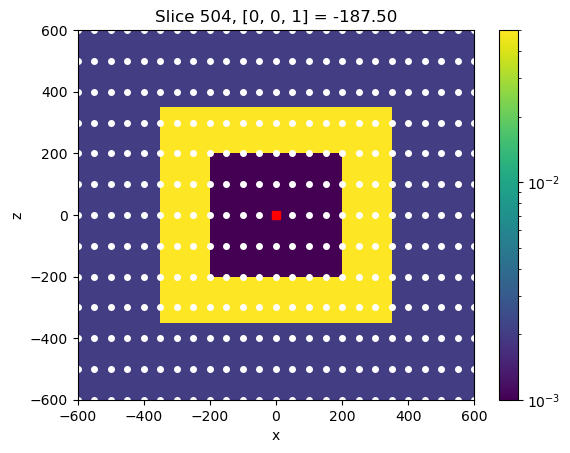

In [19]:
fig, ax = plt.subplots(1, 1)
plt.colorbar(
    ubc_mesh.plot_slice(
        model, ax=ax, pcolor_opts={"norm":LogNorm()}, 
        normal="Z",
        ind = 504
    )[0], 
    ax=ax
)

ax.set_xlim(600*np.r_[-1, 1])
ax.set_ylim(600*np.r_[-1, 1])

ax.plot(rx_locs[:, 0], rx_locs[:, 1], "wo", ms=4)
ax.plot(rx_locs[src_ind, 0], rx_locs[src_ind, 1], "rs", ms=6)

In [20]:
observed_data[src, src.receiver_list[0]]

array([-7.036259e-07, -4.456647e-07, -2.649327e-07, -1.607448e-07,
       -9.437293e-08, -5.330868e-08, -2.915128e-08, -1.547254e-08,
       -7.778253e-09, -4.083307e-09, -2.063394e-09, -1.020330e-09,
       -5.030324e-10, -2.438965e-10, -1.272593e-10, -6.604441e-11,
       -3.408438e-11, -1.715879e-11, -9.108297e-12, -4.676497e-12])

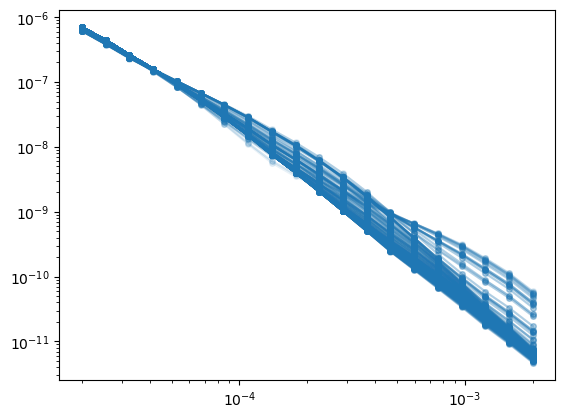

In [21]:
for src_ind in range(len(rx_locs)): 
    src = full_survey.source_list[src_ind]
    
    # plt.loglog(rx_times, -data_dict["background"][src, src.receiver_list[0]], "k", alpha=0.5)
    plt.loglog(rx_times, -observed_data[src, src.receiver_list[0]], "C0-o", ms=4, alpha=0.1)

In [22]:
src_ind = int(len(rx_locs)/2)
src_ind

217

In [23]:

source_sounding = full_survey.source_list[src_ind]
survey_sounding = tdem.Survey([source_sounding])
sim1d_true = tdem.Simulation1DLayered(
    survey=survey_sounding, thicknesses=[], sigmaMap=maps.IdentityMap(nP=1)
)

In [24]:
dpred_halfspace = sim1d_true.dpred(1./500)

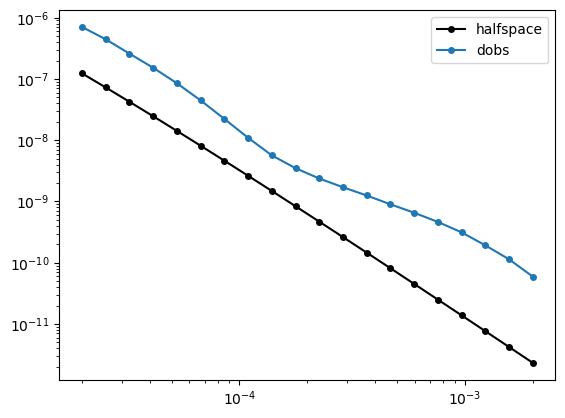

In [25]:
fig, ax = plt.subplots(1, 1)

ax.loglog(rx_times, -dpred_halfspace, "k-o", ms=4, label="halfspace")
ax.loglog(rx_times, -observed_data[source_sounding, source_sounding.receiver_list[0]], "C0-o", ms=4, label="dobs")

ax.legend()

In [26]:
# octree_mesh = discretize.load_mesh("./synthetic-data/treemesh.json")

# octree_mesh = discretize.load_mesh()

In [27]:
cs = 25
core_region = 200
npad = 12
padding_factor = 1.3

thicknesses1d = discretize.utils.unpack_widths(
    [(cs, np.int64(np.ceil(core_region/cs))), (cs, npad, padding_factor)]
)

In [28]:
np.sum(thicknesses1d)


np.float64(2615.625888268776)

In [29]:
# set up 1D inversion 
def create_inversion(
    ind,
    dobs,
    rx_times_invert=rx_times[:n_times_invert],
    rx_locs=rx_locs, 
    relative_error=0.05,
    noise_floor=1e-11,
    alpha_s = 1/cs,
    alpha_x = 1,
    rho_back = 500,
    beta0 = 200,
): 
    cs = 25
    core_region = 200
    npad = 12
    padding_factor = 1.3
    
    thicknesses1d = discretize.utils.unpack_widths(
        [(cs, np.int64(np.ceil(core_region/cs))), (cs, npad, padding_factor)]
    )
    
    rx_sounding = tdem.receivers.PointMagneticFluxTimeDerivative(
        locations=rx_locs[ind, :], times=rx_times_invert, orientation="z"
    )
    src_sounding = tdem.sources.CircularLoop(
        receiver_list=[rx_sounding], location=rx_locs[ind, :], orientation="z", 
        radius=10, 
        waveform=tdem.sources.StepOffWaveform()
    )
    survey_sounding = tdem.Survey([src_sounding])
    mesh_invert = discretize.TensorMesh([(np.r_[thicknesses1d, thicknesses1d[-1]])], origin="0")
    
    sim1d = tdem.Simulation1DLayered(
        survey=survey_sounding, thicknesses=thicknesses1d, sigmaMap=maps.ExpMap(mesh_invert)
    )

    data_invert = Data(
        survey_sounding, 
        dobs=dobs,
        standard_deviation=relative_error*np.abs(dobs) + noise_floor
    )
    
    dmis = data_misfit.L2DataMisfit(simulation=sim1d, data=data_invert)
    reg = regularization.WeightedLeastSquares(
        mesh_invert, alpha_s=alpha_s, alpha_x=alpha_x, 
        # reference_model=np.log(1./rho_back),
        # norms=norms
    )
    
    opt = optimization.InexactGaussNewton(maxIter=20)
    inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt, beta=beta0)
    
    # Defining a starting value for the trade-off parameter (beta) between the data
    # misfit and the regularization.
    starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=10)
    
    cool_beta = directives.BetaSchedule(coolingFactor=1.5, coolingRate=1)
    
    # Update the preconditionner
    update_Jacobi = directives.UpdatePreconditioner()
    
    # Options for outputting recovered models and predicted data for each beta.
    save_iteration = directives.SaveOutputDictEveryIteration(
        saveOnDisk=False,
    )
    
    
    # Updating the preconditionner if it is model dependent.
    update_jacobi = directives.UpdatePreconditioner()
    
    # Add sensitivity weights
    sensitivity_weights = directives.UpdateSensitivityWeights()
    
    target_misfit = directives.TargetMisfit()
    
    # The directives are defined as a list.
    directives_list = [
        sensitivity_weights,
        update_jacobi,
        # starting_beta,
        cool_beta,
        save_iteration,
        target_misfit,
    ]
    
    # Here we combine the inverse problem and the set of directives
    inv = inversion.BaseInversion(inv_prob, directives_list)
    return inv

In [30]:
len(rx_locs)

435

In [31]:
ind = 25
source_sounding = full_survey.source_list[ind]
inv = create_inversion(
    ind, observed_data[source_sounding, source_sounding.receiver_list[0]], 
    rx_times[:n_times_invert], rx_locs
)

In [32]:
rho_start = 500
m0 = np.log(1/rho_start) * np.ones(len(thicknesses1d)+1)
mopt = inv.run(m0)


Running inversion with SimPEG v0.24.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.00e+02  3.27e+03  0.00e+00  3.27e+03    7.54e+02      0              
   1  1.33e+02  1.15e+03  2.86e+00  1.53e+03    1.08e+03      0              
   2  8.89e+01  6.15e+01  5.77e+00  5.74e+02    8.84e+02      0              
------------------------- STOP! -------------------------
1 : 

In [33]:
iterations = len(inv.directiveList.dList[-2].outDict)

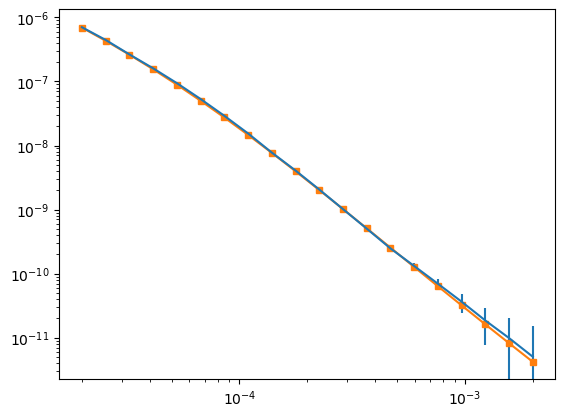

In [34]:

# plt.loglog(rx_times, -data_dict["background"][src, src.receiver_list[0]], "k", alpha=0.5)
# plt.loglog(rx_times, -data_dict[key][src, rx], "C0o", ms=4)
rx_times_invert = rx_times[:n_times_invert]
plt.errorbar(rx_times_invert, -inv.invProb.dmisfit[0][1].data.dobs, yerr=inv.invProb.dmisfit[0][1].data.standard_deviation)
plt.loglog(rx_times_invert, -inv.directiveList.dList[-2].outDict[iterations]["dpred"], "C1-s", ms=4)

(0.0001, 0.1)

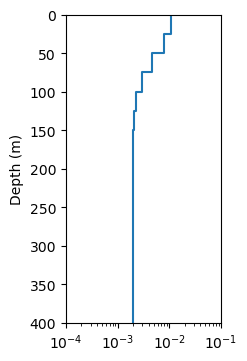

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(2, 4))
plot_1d_layer_model(
    thicknesses1d, np.exp(mopt), ax=ax, color="C0", label="recovered"
)

ax.set_ylim([400, 0])
ax.set_xlim([1e-4, 1e-1])


In [36]:

ind = 1
source_sounding = full_survey.source_list[ind]
inv = create_inversion(
    ind, observed_data[source_sounding, source_sounding.receiver_list[0]], rx_times[:n_times_invert], rx_locs
)

In [37]:
rho_start = 500
m0 = np.log(1/rho_start) * np.ones(len(thicknesses1d)+1)
mopt = inv.run(m0)



Running inversion with SimPEG v0.24.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.00e+02  3.27e+03  0.00e+00  3.27e+03    7.54e+02      0              
   1  1.33e+02  1.15e+03  2.85e+00  1.53e+03    1.08e+03      0              
   2  8.89e+01  6.22e+01  5.77e+00  5.75e+02    8.86e+02      0              
------------------------- STOP! -------------------------
1 : 

(0.0001, 0.1)

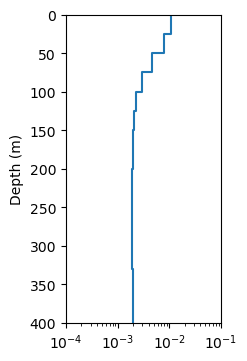

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(2, 4))
plot_1d_layer_model(
    thicknesses1d, np.exp(mopt), ax=ax, color="C0", label="recovered"
)

ax.set_ylim([400, 0])
ax.set_xlim([1e-4, 1e-1])


In [39]:
rho_start = 500
m0 = np.log(1/rho_start) * np.ones(len(thicknesses1d)+1)

In [40]:
directory = "/t40array/lheagy/2025-heagy-et-al-tle/mt-mill-1d"

In [41]:
def run_inv(ind, dobs, m0, directory=directory): 
    inv = create_inversion(ind, dobs)
    
    label_key=f"{ind}"
    
    mopt = inv.run(m0)
    np.save(f"{directory}/{label_key}_model.npy", mopt)
    
    inv_dict = inv.directiveList.dList[-2].outDict
    with open(f"{directory}/{label_key}_inv_dict.pkl", "wb") as f:
        pickle.dump(inv_dict, f)

    return label_key, mopt

In [42]:
ind=0
src = full_survey.source_list[ind]
rx = src.receiver_list[0]
run_inv(0, observed_data[src, rx], m0, directory)


Running inversion with SimPEG v0.24.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.00e+02  3.26e+03  0.00e+00  3.26e+03    7.53e+02      0              
   1  1.33e+02  1.15e+03  2.85e+00  1.53e+03    1.08e+03      0              
   2  8.89e+01  6.28e+01  5.76e+00  5.75e+02    8.88e+02      0              
------------------------- STOP! -------------------------
1 : 

('0',
 array([-4.54554757, -4.84973494, -5.37572243, -5.84158452, -6.07467361,
        -6.17235223, -6.21612041, -6.23771803, -6.2502315 , -6.25472269,
        -6.2516905 , -6.24187019, -6.22582339, -6.20625263, -6.19646476,
        -6.20352777, -6.21399349, -6.21839074, -6.21766971, -6.21638733,
        -6.21565328]))

In [43]:
from joblib import Parallel, delayed
inv_dict = {}
results = Parallel(n_jobs=48, backend='loky')(  # 'loky' is the default and most flexible
    delayed(run_inv)(
        ind, observed_data[full_survey.source_list[ind], 
        full_survey.source_list[ind].receiver_list[0]], 
        m0, directory)
    for ind in range(rx_locs.shape[0])
)

# Collect results
for (label_key, mopt) in results:
    inv_dict[label_key] = mopt


Running inversion with SimPEG v0.24.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.00e+02  3.29e+03  0.00e+00  3.29e+03    7.56e+02      0              
   1  1.33e+02  1.14e+03  2.89e+00  1.53e+03    1.09e+03      0              
   2  8.89e+01  5.75e+01  5.79e+00  5.72e+02    8.67e+02      0              
------------------------- STOP! -------------------------
1 : 

In [70]:
def load_models_and_dicts(folder):
    inv_dicts = {}
    model_arrays = {}

    for fname in os.listdir(folder):
        full_path = os.path.join(folder, fname)

        if fname.endswith("_inv_dict.pkl"):
            key = fname.replace("_inv_dict.pkl", "")
            with open(full_path, "rb") as f:
                inv_dicts[key] = pickle.load(f)

        elif fname.endswith("_model.npy"):
            key = fname.replace("_model.npy", "")
            model_arrays[key] = np.load(full_path)

    return inv_dicts, model_arrays

In [71]:
inv_dicts, models_1d = load_models_and_dicts(directory)

In [72]:
mesh1d = discretize.TensorMesh([(np.r_[thicknesses1d, thicknesses1d[-1]])], origin="0")


In [73]:
mesh1d.cell_centers

array([  12.5       ,   37.5       ,   62.5       ,   87.5       ,
        112.5       ,  137.5       ,  162.5       ,  187.5       ,
        216.25      ,  253.625     ,  302.2125    ,  365.37625   ,
        447.489125  ,  554.2358625 ,  693.00662125,  873.40860763,
       1107.93118991, 1412.81054689, 1809.15371095, 2324.39982424,
       2906.8519523 ])

In [74]:
rx_x = np.unique(rx_locs[:, 0])
rx_y = np.unique(rx_locs[:, 1])

In [75]:
grid_1d_results = discretize.utils.ndgrid(
    rx_x, rx_y, -mesh1d.cell_centers
)

In [76]:
compiled_1d_models = np.zeros(len(grid_1d_results))

for key in models_1d.keys():
    ind = int(key)
    m = models_1d[key]
    sounding_inds = (
        (rx_locs[ind, 0] == grid_1d_results[:, 0]) & 
        (rx_locs[ind, 1] == grid_1d_results[:, 1])
    )
    compiled_1d_models[sounding_inds] = np.flipud(m)

In [77]:
hx = np.diff(rx_x)
hx = np.r_[hx, hx[-1]]
hy = np.diff(rx_y)
hy = np.r_[hy, hy[-1]]

mesh_results = discretize.TensorMesh(
    [hx, hy, np.flipud(mesh1d.h[0])], origin="CCN"
)

In [78]:
mesh_results

TensorMesh: 9,135 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     29       -725.00        725.00     50.00     50.00    1.00
   y     15       -750.00        750.00    100.00    100.00    1.00
   z     21     -3,198.08          0.00     25.00    582.45    1.30

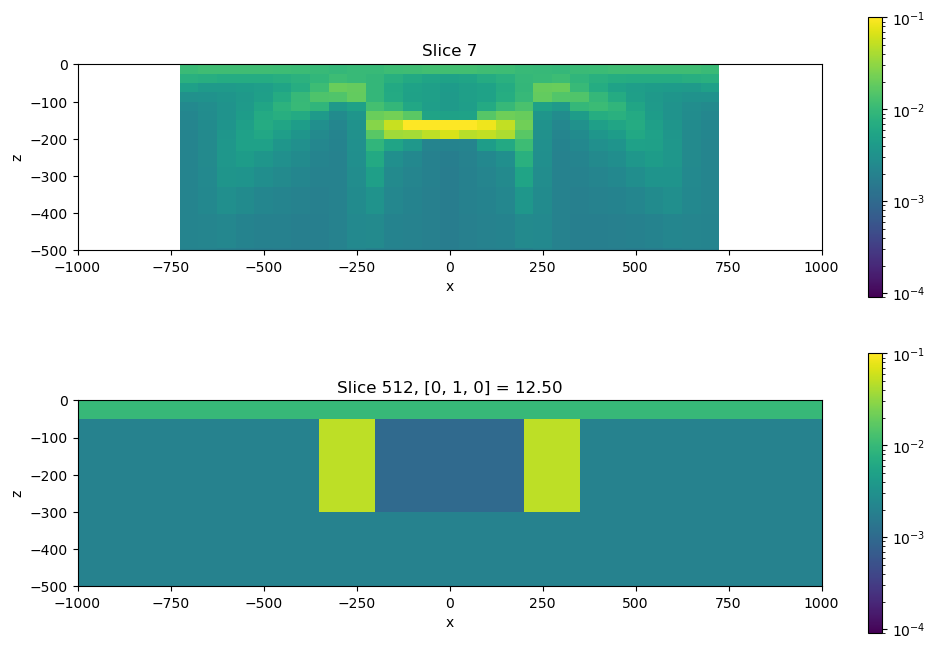

In [79]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

norm = LogNorm(vmin=9e-5, vmax=1e-1)
plt.colorbar(mesh_results.plot_slice(
    np.exp(compiled_1d_models),
    normal="Y", 
    pcolor_opts={"norm":norm},
    ax=ax[0],
    # ind=8
)[0], ax=ax[0])


plt.colorbar(
    ubc_mesh.plot_slice(
        model, ax=ax[1], pcolor_opts={"norm":norm}, 
        normal="Y",
    )[0], 
    ax=ax[1]
)


for a in ax.flatten():
    # # a.plot(target_outline_x, target_outline_z, color="k", lw=1.5)
    a.set_ylim(-500, 0)
    a.set_xlim(np.r_[-1, 1]*1000)
    a.set_aspect(1)


In [80]:
dpred_1d = np.zeros((n_times_invert, len(rx_locs)))

for k in inv_dicts.keys():
    ind = int(k)
    
    idict = inv_dicts[k]
    iterations = len(idict)
    dpred_1d[:, ind] = idict[iterations]["dpred"]

    

In [81]:
dpred_1d = dpred_1d.reshape(n_times_invert, len(rx_x), len(rx_y), order="F")

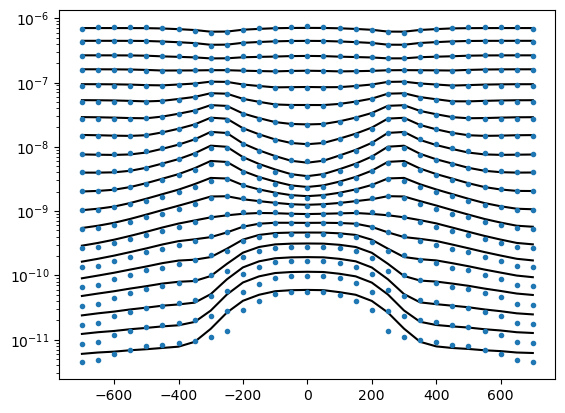

In [82]:
fig, ax = plt.subplots(1, 1)

line_number = 7

ax.semilogy(
    rx_x, -observed_data.dobs.reshape(len(rx_locs[:,0]), 20)[line_number*len(rx_x):(1+line_number)*len(rx_x), :], 
    "k-", ms=3
);

ax.semilogy(rx_x, -dpred_1d[:, :, line_number].T, "C0o", ms=3);

In [57]:
P = discretize.utils.volume_average(mesh_results, ubc_mesh)

In [58]:
interpolated_model = P * compiled_1d_models
interpolated_model[ubc_mesh.cell_centers[:, 2]>0] = np.log(1e-8)

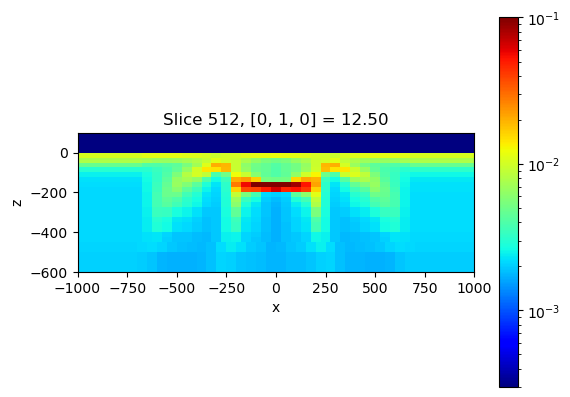

In [83]:
fig, ax = plt.subplots(1, 1)
plt.colorbar(ubc_mesh.plot_slice(
    np.exp(interpolated_model),
    pcolor_opts = {"norm": LogNorm(3e-4, 1e-1), "cmap":"jet"},
    ax=ax,
    normal="y"
)[0], ax=ax)

ax.set_xlim(np.r_[-1, 1]*1000)
ax.set_ylim(np.r_[-600, 100])
ax.set_aspect(1)

In [84]:
def load_pre_file(filepath):
    """
    Load a GIF-style .pre file (TDoctree format).

    Parameters
    ----------
    filepath : str
        Path to the .pre-style data file

    Returns
    -------
    dict
        {
            "ignore": float or None,
            "n_trx": int,
            "transmitters": list of {
                "location": list of float,
                "n_recv": int,
                "n_time": int,
                "receivers": list of {
                    "loc": (x, y, z),
                    "time": float,
                    "data": list of float
                }
            }
        }
    """
    with open(filepath, "r") as f:
        lines = [line.strip() for line in f if line.strip()]

    i = 0
    ignore_value = None
    transmitters = []

    # Parse IGNORE line if present
    if lines[i].startswith("IGNORE"):
        ignore_value = float(lines[i].split()[1])
        i += 1

    # Parse number of transmitters
    if lines[i].startswith("N_TRX"):
        n_trx = int(lines[i].split()[1])
        i += 1
    else:
        raise ValueError("Missing N_TRX line")

    while i < len(lines):
        if lines[i].startswith("TRX_LOOP"):
            i += 1
            location = list(map(float, lines[i].split()))
            i += 1
            if not lines[i].startswith("N_RECV"):
                raise ValueError("Expected N_RECV")
            n_recv = int(lines[i].split()[1])
            i += 1
            if not lines[i].startswith("N_TIME"):
                raise ValueError("Expected N_TIME")
            n_time = int(lines[i].split()[1])
            i += 1

            receivers = []
            for _ in range(n_recv * n_time):
                parts = lines[i].split()
                x, y, z = map(float, parts[0:3])
                time = float(parts[3])
                data = list(map(float, parts[4:]))
                receivers.append({
                    "loc": (x, y, z),
                    "time": time,
                    "data": data
                })
                i += 1

            transmitters.append({
                "location": location,
                "n_recv": n_recv,
                "n_time": n_time,
                "receivers": receivers
            })
        else:
            i += 1  # Skip unknown or empty lines

    return {
        "ignore": ignore_value,
        "n_trx": len(transmitters),
        "transmitters": transmitters
    }


In [85]:
sim_directory_3d = "3D-sim-1d-results"

In [86]:
discretize.TreeMesh.write_model_UBC(ubc_mesh, f"{sim_directory_3d}/model.con", np.exp(interpolated_model))

In [95]:
# load and plot dpred, 1D inversion dpred, 3D simulation dpred

In [63]:
dpred_from_3d = load_pre_file(f"{sim_directory_3d}/dpred0.txt")
dpred_values = np.zeros((n_times_invert, len(dobs["transmitters"])))

for i in range(len(dpred_from_3d["transmitters"])): 
    for j in range(n_times_invert): 
        dpred_values[j, i] = dpred_from_3d["transmitters"][i]["receivers"][j]["data"][-1]

In [64]:
dpred_values = dpred_values.reshape(n_times_invert, len(rx_x), len(rx_y), order="F")

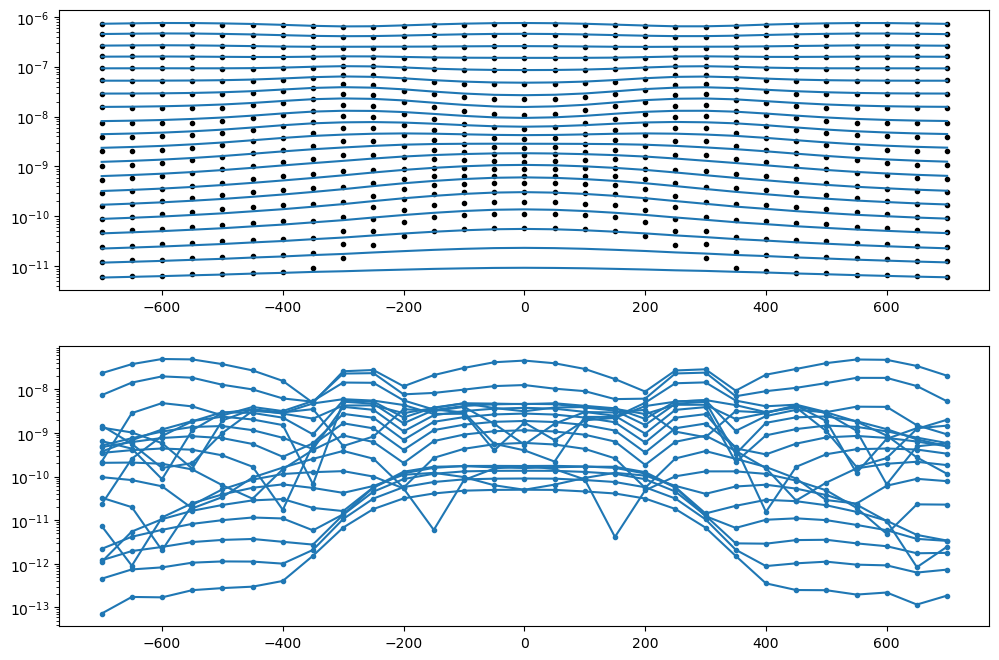

In [65]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

line_number = 7

true_data = -observed_data.dobs.reshape(len(rx_locs[:,0]), 20)[line_number*len(rx_x):(1+line_number)*len(rx_x), :]
ax[0].semilogy(
    rx_x, true_data, 
    "ko", ms=3
);

ax[0].semilogy(rx_x, dpred_values[:, :, line_number].T, "C0-");


ax[1].semilogy(
    rx_x, np.abs(true_data-dpred_values[:, :, line_number].T),
    "C0-o", ms=3
);



In [66]:
# fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# line_number = 4

# true_data = -observed_data.dobs.reshape(len(rx_locs[:,0]), 20)[line_number*len(rx_x):(1+line_number)*len(rx_x), :]
# ax[0].semilogy(
#     rx_x, true_data, 
#     "ko", ms=3
# );

# ax[0].semilogy(rx_x, -dpred_1d[:, :, line_number].T, "C1-");


# ax[1].semilogy(
#     rx_x, np.abs(true_data+dpred_1d[:, :, line_number].T),
#     "C1-o", ms=3
# );



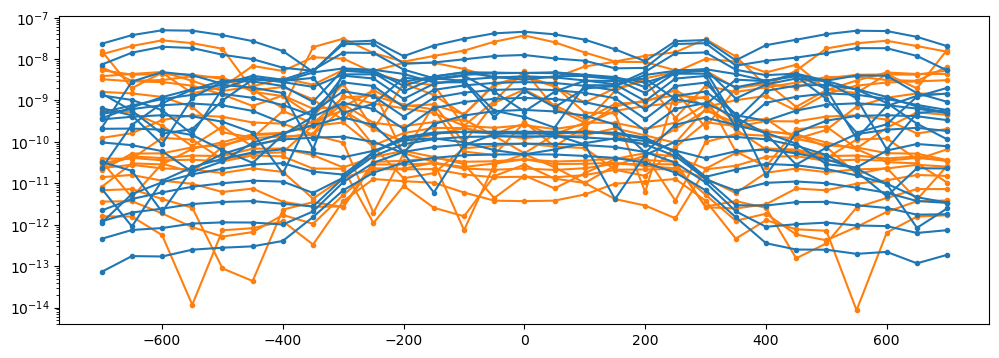

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

ax.semilogy(
    rx_x, np.abs(true_data+dpred_1d[:, :, line_number].T),
    "C1-o", ms=3
);

ax.semilogy(
    rx_x, np.abs(true_data-dpred_values[:, :, line_number].T),
    "C0-o", ms=3
);

In [68]:
len(rx_locs)

435

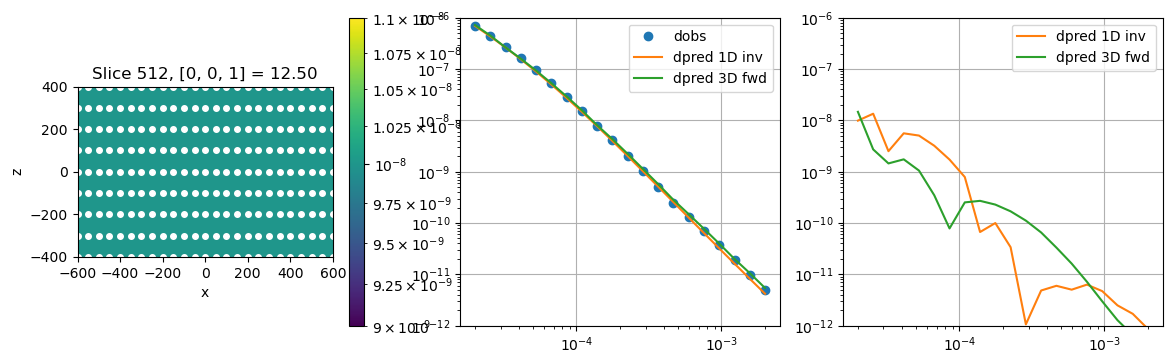

In [69]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))

src_ind = 30
source_sounding = source_list[src_ind]

plt.colorbar(
    ubc_mesh.plot_slice(
        model, ax=ax[0], pcolor_opts={"norm":LogNorm()}, 
        normal="Z",
    )[0], 
    ax=ax[0]
)

ax[0].set_xlim(600*np.r_[-1, 1])
ax[0].set_ylim(400*np.r_[-1, 1])
ax[0].set_aspect(1)

ax[0].plot(rx_locs[:, 0], rx_locs[:, 1], "wo", ms=4)
ax[0].plot(rx_locs[src_ind, 0], rx_locs[src_ind, 1], "rs", ms=6)


# ax[1].loglog(rx_times, -dpred_halfspace, "k-", ms=4, label="halfspace", alpha=0.2)
ax[1].loglog(rx_times, -observed_data[source_sounding, source_sounding.receiver_list[0]], "C0o", ms=6, label="dobs")
ax[1].loglog(rx_times, -dpred_1d.reshape(20, len(rx_x)*len(rx_y), order="F")[:, src_ind], "C1-", label="dpred 1D inv")
ax[1].loglog(rx_times, dpred_values.reshape(20, len(rx_x)*len(rx_y), order="F")[:, src_ind], "C2-", label="dpred 3D fwd")
ax[1].grid()
ax[1].legend()

true = -observed_data[source_sounding, source_sounding.receiver_list[0]]
# ax[2].loglog(rx_times, , "C0o", ms=6, label="dobs")
ax[2].loglog(rx_times, np.abs(true + dpred_1d.reshape(20, len(rx_x)*len(rx_y), order="F")[:, src_ind]), "C1-", label="dpred 1D inv")
ax[2].loglog(rx_times, np.abs(true-dpred_values.reshape(20, len(rx_x)*len(rx_y), order="F")[:, src_ind]), "C2-", label="dpred 3D fwd")
ax[2].grid()
ax[2].legend()

for a in ax[1:].flatten():
    a.set_ylim([1e-12, 1e-6])

# ax.legend()

# Make figures

In [98]:
mrec3d = discretize.TreeMesh.read_model_UBC(ubc_mesh, "inv_005.con")
dinv3d = np.loadtxt("dpred.txt")[:, -1].reshape(20, len(rx_locs), order="F")

In [143]:
depth_overburden = 60

thickness_alteration = 150
depth_alteration = 300

width_stock = 400
depth_stock = depth_alteration

extent_overburden_line = 1000

stock_end = width_stock/2 + thickness_alteration

target_section_x = [
    -np.r_[stock_end, stock_end, width_stock/2, width_stock/2, stock_end],
     np.r_[stock_end, stock_end, width_stock/2, width_stock/2, stock_end],
     np.r_[-width_stock/2, -width_stock/2, width_stock/2, width_stock/2, -width_stock/2],
    np.r_[-extent_overburden_line, extent_overburden_line],
    np.r_[-extent_overburden_line, extent_overburden_line],
]

target_section_z = [
    np.r_[-depth_alteration, -depth_overburden, -depth_overburden, -depth_alteration, -depth_alteration],
    np.r_[-depth_alteration, -depth_overburden, -depth_overburden, -depth_alteration, -depth_alteration],
    np.r_[-depth_alteration, -depth_overburden, -depth_overburden, -depth_alteration, -depth_alteration],
    np.r_[-depth_overburden, -depth_overburden],
    np.r_[0, 0],
]

target_slice_x = [
    np.r_[-stock_end, -stock_end, stock_end, stock_end, -stock_end], 
    np.r_[-width_stock/2, -width_stock/2, width_stock/2, width_stock/2, -width_stock/2], 
]

target_slice_y = [
    np.r_[-stock_end, stock_end, stock_end, -stock_end, -stock_end], 
    np.r_[-width_stock/2, width_stock/2, width_stock/2, -width_stock/2, -width_stock/2], 
]

In [296]:
np.unique(model)

array([1.e-08, 1.e-03, 2.e-03, 1.e-02, 5.e-02])

In [313]:
rcParams["font.size"] = 12

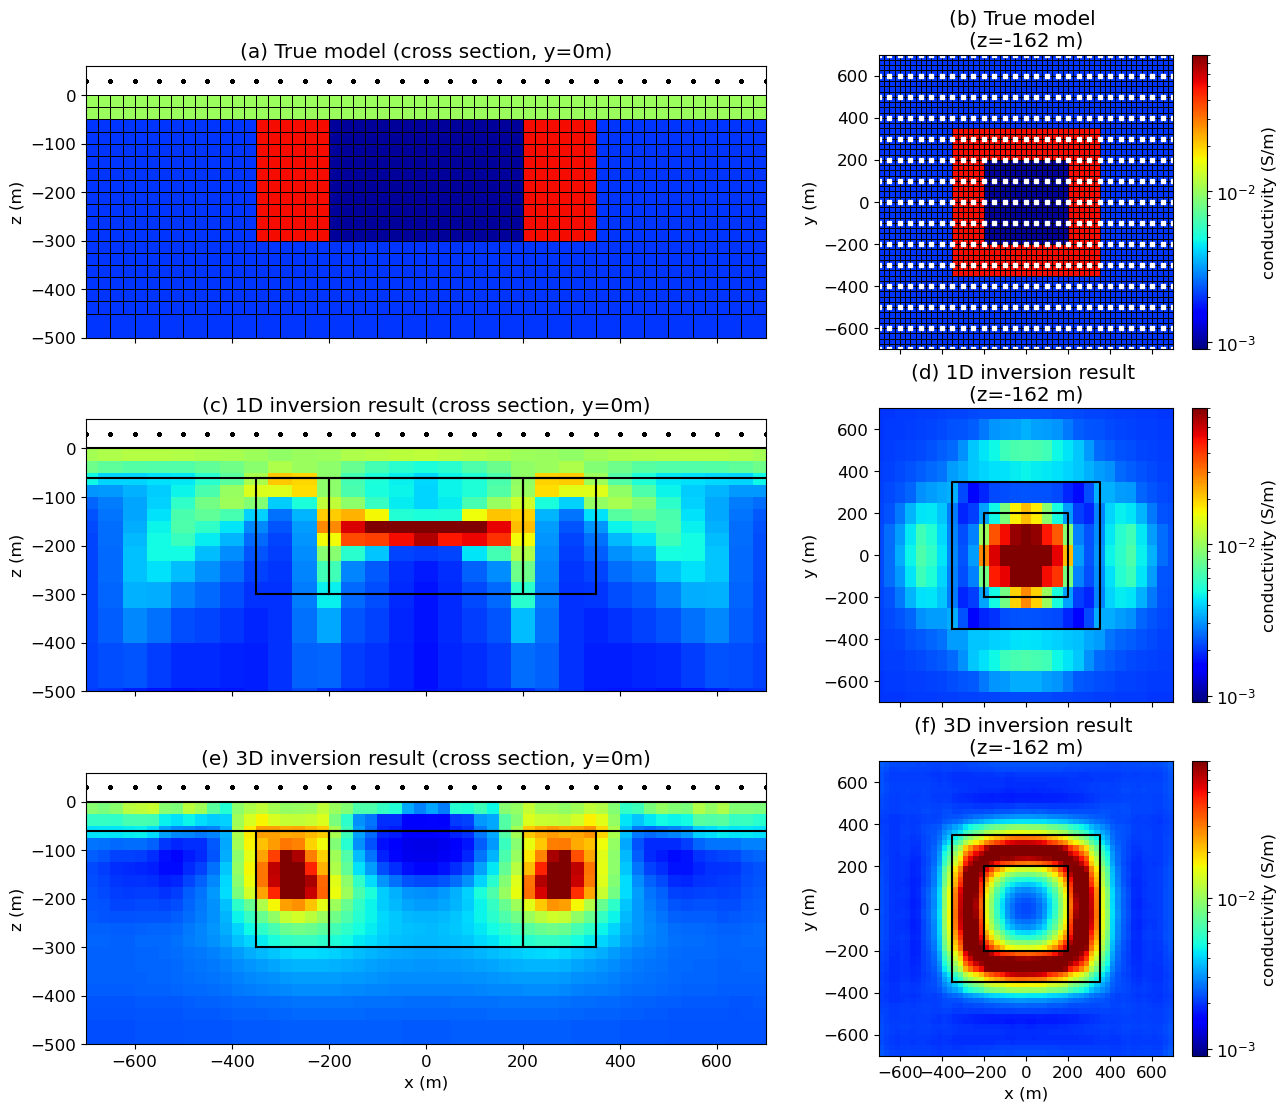

In [317]:
fig, ax = plt.subplots(3, 2, figsize=(15, 13), sharex=True, gridspec_kw={"width_ratios": [1.8, 1]})


pcolor_opts = {"norm":LogNorm(vmin=9e-4, vmax=8e-2), "cmap":"jet"}

ind3d = 505
ind1d = 14

# -------------- True Model ---------------
model_plot = model.copy()
model_plot[model_plot == 1e-8] = np.nan
# cb = plt.colorbar(
ubc_mesh.plot_slice(
    model_plot, ax=ax[0, 0], pcolor_opts=pcolor_opts, 
    normal="y",
    grid_opts={"color":"k","lw":0.5}
    # ind=1044
# )[0], ax=ax[0, 0]
)
cb = plt.colorbar(
    ubc_mesh.plot_slice(
        model_plot, ax=ax[0, 1], pcolor_opts=pcolor_opts, 
        normal="z",
        grid_opts={"color":"k","lw":0.5},
        ind=ind3d,
    )[0], ax=ax[0, 1]
)
cb.set_label("conductivity (S/m)")

# -------------- 1D inv ---------------
# cb = plt.colorbar(
mesh_results.plot_slice(
    np.exp(compiled_1d_models),
    normal="Y", 
    pcolor_opts=pcolor_opts,
    ax=ax[1, 0],
    # )[0], ax=ax[1, 0]
)

cb = plt.colorbar(
    mesh_results.plot_slice(
        np.exp(compiled_1d_models),
        normal="Z", 
        pcolor_opts=pcolor_opts,
        ind=ind1d,
        ax=ax[1, 1],
    )[0], ax=ax[1, 1]
)
cb.set_label("conductivity (S/m)")

# -------------- 3D inv ---------------
mrec3d_plot = mrec3d.copy()
mrec3d_plot[mrec3d_plot == 1e-8] = np.nan
# cb = plt.colorbar(
ubc_mesh.plot_slice(
    mrec3d_plot, ax=ax[2, 0], pcolor_opts=pcolor_opts, 
    normal="y",
    # grid_opts={"color":"k","lw":0.5}
        # ind=1044
    # )[0], ax=ax[2, 0],
)
cb = plt.colorbar(
    ubc_mesh.plot_slice(
        mrec3d_plot, ax=ax[2, 1], pcolor_opts=pcolor_opts, 
        normal="Z",
        # grid_opts={"color":"k","lw":0.5}
        ind=ind3d,
    )[0], ax=ax[2, 1],
)
cb.set_label("conductivity (S/m)")

# ------------ Titles and such ---------------
ax[0, 0].set_title("(a) True model (cross section, y=0m)")
ax[1, 0].set_title("(c) 1D inversion result (cross section, y=0m)")
ax[2, 0].set_title("(e) 3D inversion result (cross section, y=0m)")

ax[0, 1].set_title(f"(b) True model \n(z={ubc_mesh.cell_centers_z[ind3d]:1.0f} m)")
ax[1, 1].set_title(f"(d) 1D inversion result \n(z={mesh_results.cell_centers_z[ind1d]:1.0f} m)")
ax[2, 1].set_title(f"(f) 3D inversion result \n(z={ubc_mesh.cell_centers_z[ind3d]:1.0f} m)")

for a in ax[1:, 0]:
    for outline_x, outline_z in zip(target_section_x, target_section_z):
        a.plot(outline_x, outline_z, color="k")

for a in ax[1:, 1]:
    for outline_x, outline_y in zip(target_slice_x, target_slice_y):
        a.plot(outline_x, outline_y, color="k")


for a in ax[:, 0].flatten(): 
    a.set_xlim(730*np.r_[-1, 1])
    a.set_ylim(np.r_[-500, 60])
    a.plot(rx_locs[:, 0], rx_locs[:, 2], "ko", ms=2)
    a.set_aspect(1)
    a.set_xlabel("")
    a.set_ylabel("z (m)")

for a in ax[:, 1].flatten(): 
    a.set_xlim(700*np.r_[-1, 1])
    a.set_ylim(700*np.r_[-1, 1])
    # a.plot(rx_locs[:, 0], rx_locs[:, 2], "ko", ms=2)
    a.set_aspect(1)
    a.set_xlabel("")
    a.set_ylabel("y (m)")
    # a.set_ylabel("z (m)")

for a in ax[-1, :].flatten(): 
    a.set_xlabel("x (m)")

ax[0, 1].plot(rx_locs[:, 0], rx_locs[:, 1], "ws", ms=3)

In [318]:
rx_x

array([-700., -650., -600., -550., -500., -450., -400., -350., -300.,
       -250., -200., -150., -100.,  -50.,    0.,   50.,  100.,  150.,
        200.,  250.,  300.,  350.,  400.,  450.,  500.,  550.,  600.,
        650.,  700.])

In [319]:
rx_y

array([-700., -600., -500., -400., -300., -200., -100.,    0.,  100.,
        200.,  300.,  400.,  500.,  600.,  700.])

In [154]:
len(rx_y)

15

In [320]:
from matplotlib import rcParams
rcParams["font.size"] = 14

In [168]:
true_data.shape

(29, 20)

Text(0.5, 0, 'x (m)')

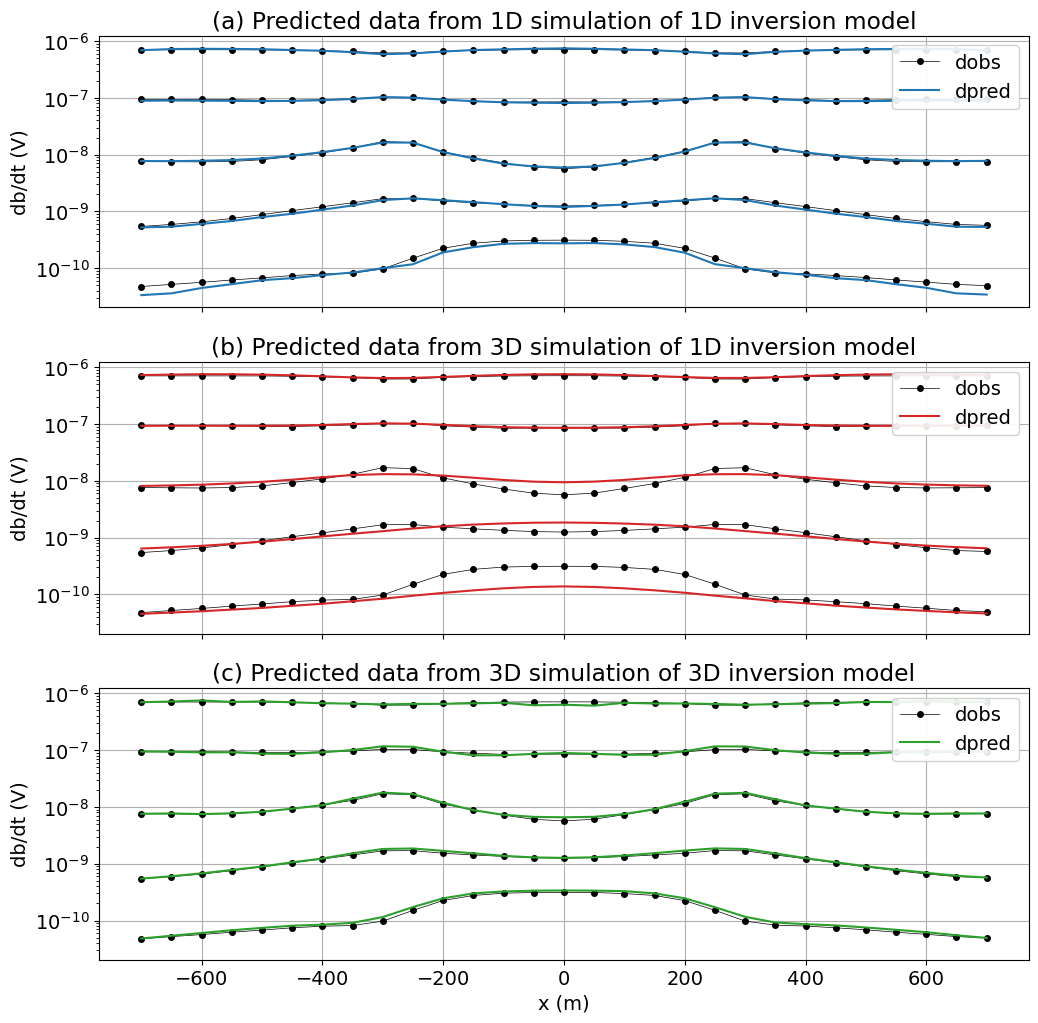

In [327]:
fig, ax = plt.subplots(3, 1, figsize=(12, 12), sharex=True, sharey=True)

dt = 4 # downsample in time (show every second time channel)
line_number = 7

true_data = -observed_data.dobs.reshape(len(rx_locs[:,0]), 20)[line_number*len(rx_x):(1+line_number)*len(rx_x), :]

for a in ax:
    a.semilogy(
        rx_x, true_data[:, ::dt], 
        "ko-", ms=4, lw=0.5
    );
    a.grid()
    a.plot([np.nan], [np.nan], "ko-", label="dobs", ms=4, lw=0.5)
    
ax[0].semilogy(rx_x, -dpred_1d[::dt, :, line_number].T, "C0", lw=1.5)
ax[0].plot([np.nan], [np.nan], "C0", label="dpred")
ax[0].set_title("(a) Predicted data from 1D simulation of 1D inversion model")

ax[1].semilogy(rx_x, dpred_values[::dt, :, line_number].T, "C3", lw=1.5);
ax[1].set_title("(b) Predicted data from 3D simulation of 1D inversion model")
ax[1].plot([np.nan], [np.nan], "C3", label="dpred")

ax[2].semilogy(rx_x, dinv3d[::dt, line_number*len(rx_x):(line_number+1)*len(rx_x)].T, "C2", lw=1.5);
ax[2].set_title("(c) Predicted data from 3D simulation of 3D inversion model")
ax[2].plot([np.nan], [np.nan], "C2", label="dpred")

for a in ax: 
    a.set_ylabel("db/dt (V)")
    a.legend(loc=1, framealpha=0.9)
# true_data = -observed_data.dobs.reshape(len(rx_locs[:,0]), 20)[line_number*len(rx_x):(1+line_number)*len(rx_x), :]
ax[-1].set_xlabel("x (m)")

In [167]:

rcParams["font.size"] = 14

In [169]:
rx_locs.shape

(435, 3)

In [171]:
rx_locs[217, :]

array([ 0.,  0., 30.])

In [173]:
dpred_1d.shape

(20, 29, 15)

In [175]:
rx_y[7]

np.float64(0.0)

In [178]:
dpred_1d.shape

(20, 29, 15)

In [179]:
len(rx_x)

29

In [181]:
rx_x[14]

np.float64(0.0)

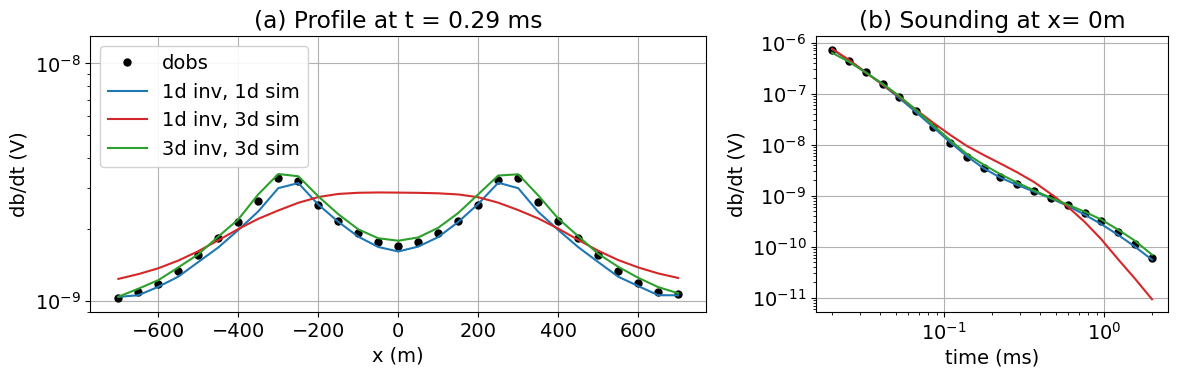

In [328]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={"width_ratios": [1.75, 1]})

# time_ind = 19 
time_ind = 11
sounding_ind = 217
line_number = 7
rx_x_ind = 14

true_data = -observed_data.dobs.reshape(len(rx_locs[:,0]), 20)[line_number*len(rx_x):(1+line_number)*len(rx_x), :]
true_data_sounding = -observed_data.dobs.reshape(len(rx_locs[:,0]), 20)[sounding_ind, :]


ax[0].semilogy(rx_x, true_data[:, time_ind], "ko", ms=5, lw=0.0, label="dobs"); 
ax[0].semilogy(rx_x, -dpred_1d[time_ind, :, line_number].T, "C0", lw=1.5, label="1d inv, 1d sim")
ax[0].semilogy(rx_x, dpred_values[time_ind, :, line_number].T, "C3", lw=1.5, label="1d inv, 3d sim");
ax[0].semilogy(rx_x, dinv3d[time_ind, line_number*len(rx_x):(1+line_number)*len(rx_x)].T, "C2", lw=1.5, label="3d inv, 3d sim");
# ax[0].set_ylim(9e-10, 1e-8)

ax[1].loglog(rx_times*1e3, true_data_sounding, "ko", ms=5, lw=0.0, label="dobs"); 
ax[1].loglog(rx_times*1e3, -dpred_1d[:, rx_x_ind, line_number].T, "C0", lw=1.5, label="1d inv, 1d sim")
ax[1].loglog(rx_times*1e3, dpred_values[:, rx_x_ind, line_number].T, "C3", lw=1.5, label="1d inv, 3d sim");
ax[1].loglog(rx_times*1e3, dinv3d[:, sounding_ind].T, "C2", lw=1.5, label="3d inv, 3d sim");

ax[0].legend(loc=2, framealpha=0.9)

ax[0].set_ylim([9e-10, 1.3e-8])

for a in ax: 
    a.set_ylabel("db/dt (V)")
    a.grid("both")
# true_data = -observed_data.dobs.reshape(len(rx_locs[:,0]), 20)[line_number*len(rx_x):(1+line_number)*len(rx_x), :]

ax[0].set_title(f"(a) Profile at t = {rx_times[time_ind]*1e3:1.2f} ms")
ax[1].set_title(f"(b) Sounding at x= {rx_x[rx_x_ind]:1.0f}m")

ax[0].set_xlabel("x (m)")
ax[1].set_xlabel("time (ms)")
plt.tight_layout()

In [239]:
true_slice = observed_data.dobs.reshape(len(rx_locs[:,0]), 20)[:, time_ind]
true_slice = true_slice.reshape(len(rx_x), len(rx_y), order="F")

Text(0.5, 1.0, '(c) Misfit \nt=0.29 ms')

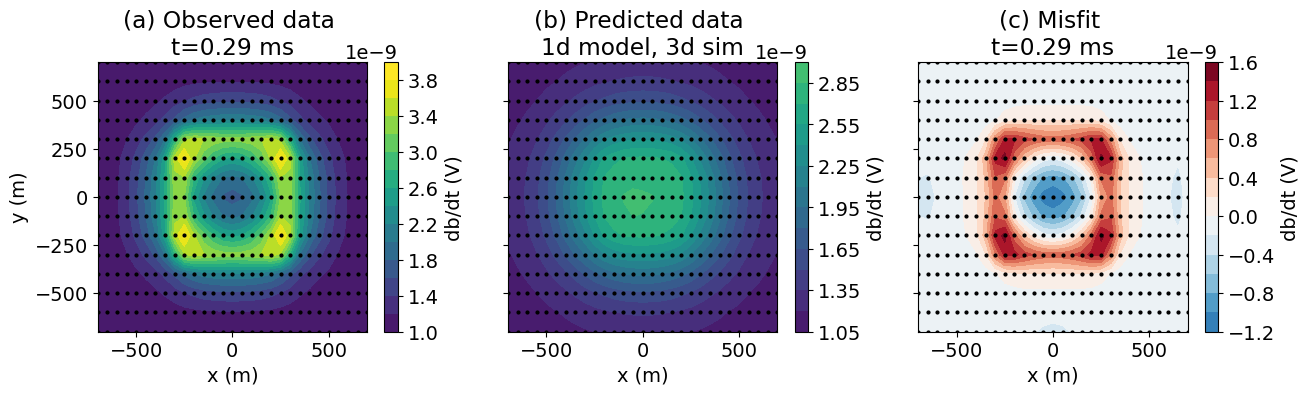

In [326]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 3.5)) 

norm = Normalize(vmin=9e-10, vmax=3.8e-9)

cb = plt.colorbar(ax[0].contourf(
    rx_x, rx_y, -true_slice.T, norm=norm, levels=15
), ax=ax[0])

cb.set_label("db/dt (V)")

cb = plt.colorbar(ax[1].contourf(
    rx_x, rx_y, dpred_values[time_ind, :, :].T, norm=norm, levels=15
), ax=ax[1])
cb.set_label("db/dt (V)")

cb = plt.colorbar(ax[2].contourf(
    rx_x, rx_y, -true_slice.T - dpred_values[time_ind, :, :].T, levels=15, 
    cmap="RdBu_r", norm=Normalize(vmin=-1.6e-9, vmax=1.6e-9)
), ax=ax[2])
cb.set_label("db/dt (V)")

for a in ax.flatten():
    a.plot(rx_locs[:, 0], rx_locs[:, 1], "ko", ms=2)
    a.set_aspect(1)
    a.set_xlabel("x (m)")
    a.set_ylabel("")
ax[0].set_ylabel("y (m)")

ax[0].set_title(f"(a) Observed data \nt={rx_times[time_ind]*1e3:1.2f} ms")
ax[1].set_title("(b) Predicted data \n1d model, 3d sim")
ax[2].set_title(f"(c) Misfit \nt={rx_times[time_ind]*1e3:1.2f} ms")